- https://ubuntu.com/blog/getting-started-with-cuda-on-ubuntu-on-wsl-2
- https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [66]:
from googletrans import Translator # Translation library
import json # JSON library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import seaborn as sns # visualization
import matplotlib as mpl


# Set image resolution
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()

In [67]:
data = pd.read_excel('data/train_sentiment_analysis.xlsx')
data.head(5)

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1.0,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1.0,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1.0,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1.0,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1.0,Hotel


In [68]:
n_hotel = len(data[data['Attraction'] == 'Hotel'])
n_rest = len(data[data['Attraction'] == 'Restaurant'])
n = len(data)

print(f'Number of hotels: {n_hotel}')
print(f'Number of restaurants: {n_rest}')
print(f'Number of reviews: {n}')

Number of hotels: 16565
Number of restaurants: 8450
Number of reviews: 30212


In [69]:
count_hotel_label = {}
for label in data.Polarity.unique():
    count_hotel_label[label] = len(data[(data['Attraction'] == 'Hotel') & (data['Polarity'] == label)])
    print(f'Hotels with label {label}: {count_hotel_label[label]}')

count_rest_label = {}
for label in data.Polarity.unique():
    count_rest_label[label] = len(data[(data['Attraction'] == 'Restaurant') & (data['Polarity'] == label)])
    print(f'Restaurants with label {label}: {count_rest_label[label]}')

count_label = {}
for label in data.Polarity.unique():
    count_label[label] = len(data[data['Polarity'] == label])
    print(f'Reviews with label {label}: {count_label[label]}')

Hotels with label 1.0: 259
Hotels with label 2.0: 307
Hotels with label 3.0: 768
Hotels with label 4.0: 2339
Hotels with label 5.0: 12892
Restaurants with label 1.0: 208
Restaurants with label 2.0: 278
Restaurants with label 3.0: 667
Restaurants with label 4.0: 1943
Restaurants with label 5.0: 5354
Reviews with label 1.0: 547
Reviews with label 2.0: 730
Reviews with label 3.0: 2121
Reviews with label 4.0: 5878
Reviews with label 5.0: 20936


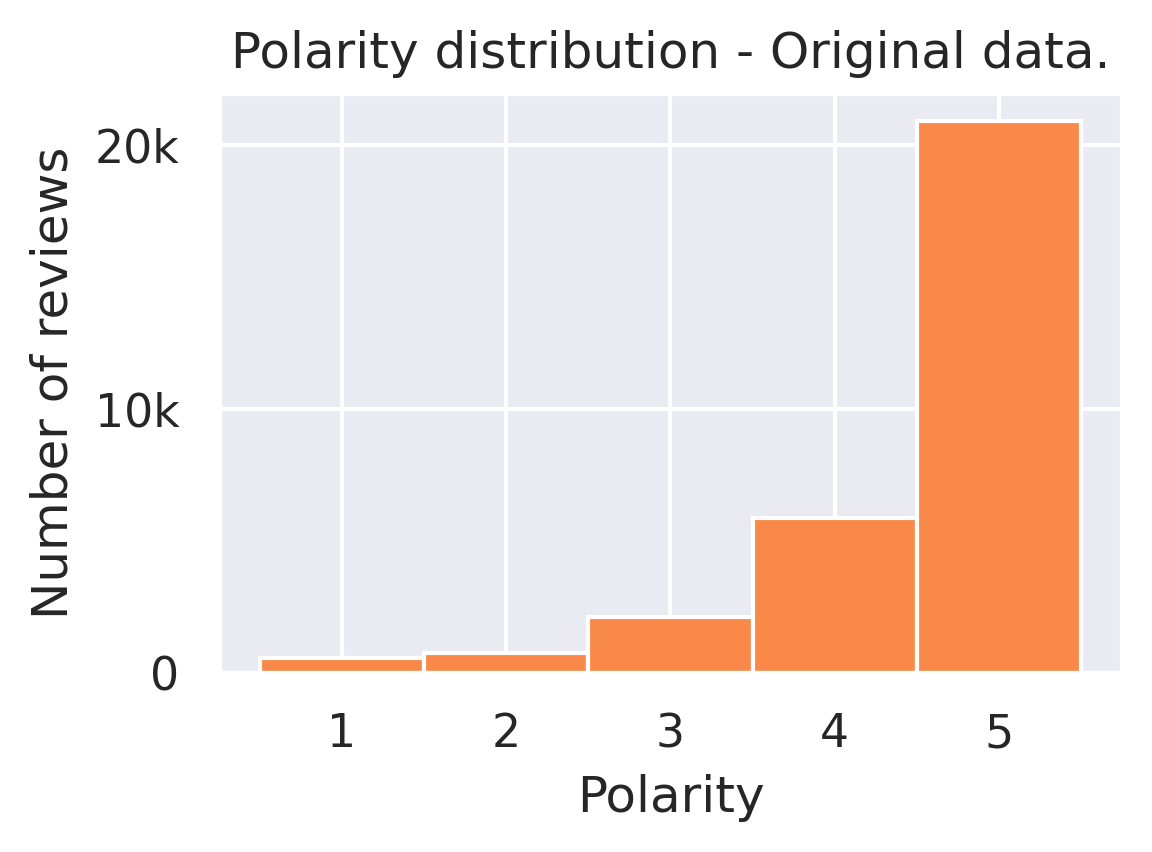

In [90]:
fig, ax = plt.subplots(figsize=(4,3))

ax.hist(data['Polarity'], bins=[0.001, 1.001, 2.001, 3.001, 4.001, 5.001], color = '#f98948')
ax.set_title('Polarity distribution - Original data.')
ax.set_xlabel('Polarity')
ax.set_ylabel('Number of reviews')
ax.grid(True)
ax.set_yticks([0, 10000, 20000], [0, '10k', '20k'])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], [1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig('images/polarity_distribution_original.png')

In [136]:
# Generator for getting lines from json file
def get_line(path):
    with open(path) as a_file:
        for line in a_file:
            yield line

In [137]:
review_path = 'data/yelp/yelp_academic_dataset_review.json'
business_path = 'data/yelp/yelp_academic_dataset_business.json'

In [138]:
# Open business dataset
business_list = []
with open(business_path) as a_file:
    for line in a_file:
        business_list.append(json.loads(line))

business_list[0]

{'business_id': 'Pns2l4eNsfO8kk83dixA6A',
 'name': 'Abby Rappoport, LAC, CMQ',
 'address': '1616 Chapala St, Ste 2',
 'city': 'Santa Barbara',
 'state': 'CA',
 'postal_code': '93101',
 'latitude': 34.4266787,
 'longitude': -119.7111968,
 'stars': 5.0,
 'review_count': 7,
 'is_open': 0,
 'attributes': {'ByAppointmentOnly': 'True'},
 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
 'hours': None}

In [139]:
restaurant_id = []
hotel_id = []

for business in business_list:
    categories = business['categories']
    if categories:
        categories = categories.split(',')
        if 'Restaurants' in categories:
            restaurant_id.append(business['business_id'])
        if 'Hotels' in categories:
            hotel_id.append(business['business_id'])

del business_list

In [140]:
print(len(restaurant_id), len(hotel_id))
print(hotel_id[0])

15290 836
xM6LoUcnpDpMBzXs_7dXAg


In [141]:
reviews = get_line(review_path) # Generator for getting reviews
review = json.loads(next(reviews)) # Review example

review

{'review_id': 'KU_O5udG6zpxOg-VcAEodg',
 'user_id': 'mh_-eMZ6K5RLWhZyISBhwA',
 'business_id': 'XQfwVwDr-v0ZS3_CbbE5Xw',
 'stars': 3.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': "If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.",
 'date': '2018-07-07 22:09:11'}

In [142]:
yelp_df = pd.DataFrame(columns=['Attraction', 'Opinion', 'Polarity'])
yelp_df

,Attraction,Opinion,Polarity


In [143]:
# Max number of reviews per label
top_hotel = max(count_hotel_label.values()) # Hotels
top_rest = max(count_rest_label.values()) # Restaurants
top = max(count_label.values()) # All reviews

count = 0 # Number of reviews added

# While labels invalanced...
while (min(count_hotel_label.values()) < top_hotel) or (min(count_rest_label.values()) < top_rest):
    try:
        review = json.loads(next(reviews)) # Load next review
    except StopIteration:
        print('No more reviews')
        break

    id = review['business_id'] # Get business id

    # If id hotel or restaurant and label is not top yet...
    if (id in hotel_id and count_hotel_label[review['stars']]<top_hotel)\
        or (id in restaurant_id and count_rest_label[review['stars']]<top_rest):

        count += 1 # Update count

        # Review dictionary to add to dataframe
        review_dict = {'Attraction': None,
                        'Opinion': review['text'],
                        'Polarity': review['stars']}

        # Count hotel or restaurant
        if review['business_id'] in hotel_id:
            review_dict['Attraction'] = 'Hotel'
            count_hotel_label[review['stars']] += 1
            count_label[review['stars']] += 1
        else:
            review_dict['Attraction'] = 'Restaurant'
            count_rest_label[review['stars']] += 1
            count_label[review['stars']] += 1

        # Add review to dataframe
        yelp_df = pd.concat([yelp_df, pd.DataFrame(review_dict, index=[0])])
        if count % 100 == 0:
            clear_output(wait=True)
            print(f'Added {count} reviews')
            print(count_hotel_label)
            print(count_rest_label)

Added 49900 reviews
{1.0: 11519, 2.0: 5647, 3.0: 6398, 4.0: 11689, 5.0: 12892}
{1.0: 5354, 2.0: 5354, 3.0: 5354, 4.0: 5354, 5.0: 5354}
No more reviews


In [144]:
print(len(yelp_df))
yelp_df.head(5)

49919


,Attraction,Opinion,Polarity
0,Restaurant,Family diner. Had the buffet. Eclectic assortm...,3.0
0,Restaurant,The bun makes the Sonoran Dog. It's like a snu...,4.0
0,Restaurant,"Yes, this is the only sushi place in town. How...",4.0
0,Restaurant,I was really between 3 and 4 stars for this on...,4.0
0,Hotel,"Comfortable bed, good breakfast, fast internet...",4.0


[]

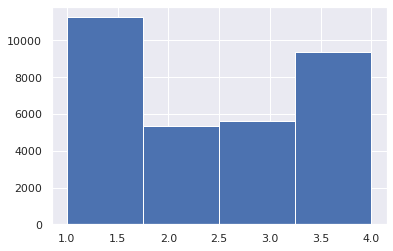

In [145]:
plt.hist(yelp_df[yelp_df['Attraction'] == 'Hotel']['Polarity'], bins=4)
plt.plot()

[]

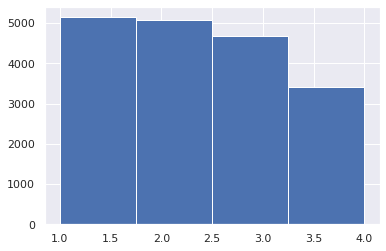

In [146]:
plt.hist(yelp_df[yelp_df['Attraction'] == 'Restaurant']['Polarity'], bins=4)
plt.plot()

In [147]:
# Save dataset
# yelp_df.to_csv('data/yelp_df_augmented.csv')

In [164]:
# Add empty column for translation
yelp_df['Translation'] = [None for i in range(len(yelp_df))]

In [168]:
# Split in 4 datasets
yelp_df_1 = yelp_df[:int(len(yelp_df)/4)]
yelp_df_2 = yelp_df[int(len(yelp_df)/4):int(len(yelp_df)/2)]
yelp_df_3 = yelp_df[int(len(yelp_df)/2):int(len(yelp_df)*3/4)]
yelp_df_4 = yelp_df[int(len(yelp_df)*3/4):]

# Check length
print(len(yelp_df_1), len(yelp_df_2), len(yelp_df_3), len(yelp_df_4))

12479 12480 12480 12480


In [169]:
# Save datasets
yelp_df_1.to_csv('data/augmentation/yelp_df_1.csv')
yelp_df_2.to_csv('data/augmentation/yelp_df_2.csv')
yelp_df_3.to_csv('data/augmentation/yelp_df_3.csv')
yelp_df_4.to_csv('data/augmentation/yelp_df_4.csv')

In [171]:
yelp_df_1.head(5)

,Attraction,Opinion,Polarity,Translation
0,Restaurant,Family diner. Had the buffet. Eclectic assortm...,3.0,None
0,Restaurant,The bun makes the Sonoran Dog. It's like a snu...,4.0,None
0,Restaurant,"Yes, this is the only sushi place in town. How...",4.0,None
0,Restaurant,I was really between 3 and 4 stars for this on...,4.0,None
0,Hotel,"Comfortable bed, good breakfast, fast internet...",4.0,None


## Translation

In [2]:
# Save augmented data
# aug_data.to_csv('data/aug_data.csv', index=False)
data = pd.read_csv('data/augmentation/yelp_df_2.csv')

In [3]:
# Count translated reviews
count_translated = 0
for review in data['Translation']:
    if type(review) == str:
        count_translated += 1

print(count_translated, len(data))

0 12480


In [5]:
from googletrans import Translator # Translation library
translator = Translator()

# Example
translator.translate('This is a test', src='en', dest='es').text

'Esto es una prueba'

In [15]:
data.head()

,Unnamed: 0,Attraction,Opinion,Polarity,Translation
0,0,Hotel,Great location. Clean. Old Florida feel only c...,4.0,NaN
1,0,Hotel,A comfortable stay! Friendly service & clean r...,4.0,NaN
2,0,Hotel,"Hotel is in a great location, the bed was supe...",3.0,NaN
3,0,Hotel,"Like many others, I had a sub-optimal experien...",2.0,NaN
4,0,Hotel,This is your standard Hampton Inn - the rates ...,4.0,NaN


In [16]:
from googletrans import Translator # Translation library
from IPython.display import clear_output # clear output
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

translator = Translator() # Create translator object

# Example
translator.translate('This is a test', src='en', dest='es').text

# Load data to translate
data = pd.read_csv('data/augmentation/yelp_df_3.csv')

# SI HAY UN ERROR, COMENTA EL ANTERIOR Y CARGA DONDE SE QUEDO, AQUI:
# data = pd.read_csv('data/augmentation/yelp_df_3_translated.csv')

# Translate and save

count = 0 # Number of reviews translated
for id in data.index:
    if type(data.at[id, 'Translation']) != str: # If translation not done yet
        opinion = str(data.at[id, 'Opinion'])

        if len(opinion) > 5000:  # Translate should be less than 5000 characters
            opinion = opinion[:5000].copy()

        # Try to translate, otherwise save dataframe in current state
        try:
            data.at[id, 'Translation'] = translator.translate(opinion, src='en', dest='es').text
        except:
            data.to_csv('data/augmentation/yelp_df_4_translated.csv', index=False)
            print('Error')
            break

        count += 1 # Update count

        # Every 100 translations, show progress and save dataframe
        if count % 100 == 0:
            # Save augmented data
            data.to_csv('data/augmentation/yelp_df_4_translated.csv', index=False)
            print(f'{count} reviews translated')
            clear_output(wait=True)

# If translation was successful, save dataframe
data.to_csv('data/augmentation/yelp_df_4_translated.csv', index=False)


Great location. Clean. Old Florida feel only complaint is bed had dip in and not very comfy.
Error


TO-DO:
1. Separar augmented dataset a hoteles y restaurantes (solamente fijarnos en esas dos categorias).
2. Vamos a hacer dos clasificadores:
    - Uno para hoteles y otro para restaurantes.
3. Datos originales: Separa desde antes 80/20, 20% para validación. Entrenar multilingual pero evaluar solo en el validation en español.

In [9]:
files = ['data/augmentation/yelp_df_1_translated.csv',
        'data/augmentation/yelp_df_2_translated.csv',
        'data/augmentation/yelp_df_3_translated.csv',
        'data/augmentation/yelp_df_4_translated.csv']

df = pd.read_csv(files[0])
for i in range(1, 4):
    df = pd.concat([df, pd.read_csv(files[i])])

# reset index
df = df.reset_index(drop=True)

# save dataframe
df.drop(columns=['Unnamed: 0'], inplace=True)
df.to_csv('data/yelp_translated.csv', index=False)

In [10]:
df = pd.read_csv('data/yelp_translated.csv')

In [11]:
len(df)

49919

In [12]:
df.head(3)

,Attraction,Opinion,Polarity,Translation
0,Restaurant,Family diner. Had the buffet. Eclectic assortm...,3.0,Cena familiar. Tenía el buffet. Surtido ecléct...
1,Restaurant,The bun makes the Sonoran Dog. It's like a snu...,4.0,El bollo lo hace el Perro Sonorense. Es como u...
2,Restaurant,"Yes, this is the only sushi place in town. How...",4.0,"Sí, este es el único lugar de sushi en la ciud..."


(array([5146., 5076., 4687., 3411.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

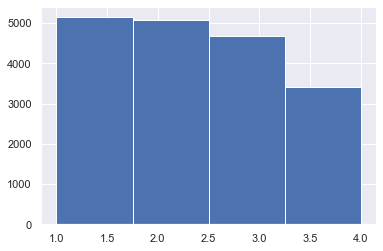

In [16]:
plt.hist(df[df['Attraction'] == 'Restaurant']['Polarity'], bins=4)

(array([11264.,  5343.,  5634.,  9358.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

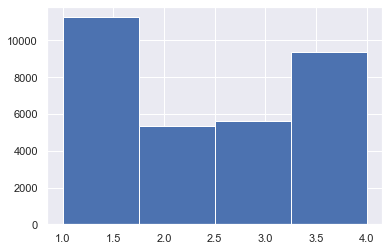

In [17]:
plt.hist(df[df['Attraction'] == 'Hotel']['Polarity'], bins=4)

In [ ]:
data = pd.read_excel('data/train_sentiment_analysis.xlsx')
data.head()

In [ ]:
# Merge Title and Opinion columns
for i in range(len(data)):
    data.loc[i, 'Opinion'] = str(data.loc[i, 'Title']) + '. ' + str(data.loc[i, 'Opinion'])

# Drop the Title column
data = data.drop(columns=['Title'])

# Drop rows with NAN in Opinion column
data = data.dropna(subset=['Opinion'])
data.head()

In [ ]:
# Save data in CSV file
data.to_csv('data/train_data.csv', index=False)

In [71]:
# Save augmented data
# aug_data.to_csv('data/aug_data.csv', index=False)
data2 = pd.read_csv('data/augmentation/yelp_df_augmented.csv')

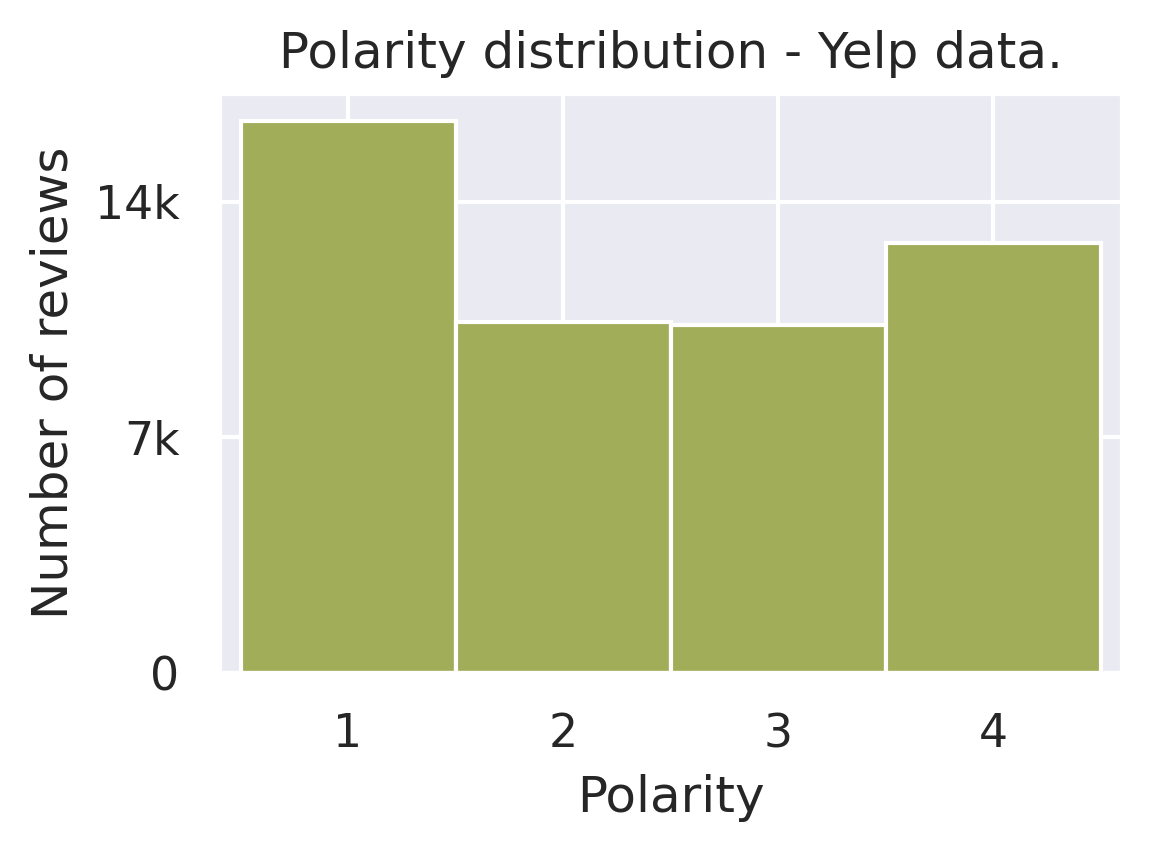

In [94]:
fig, ax = plt.subplots(figsize=(4,3))

ax.hist(data2['Polarity'], bins=[0.001, 1.001, 2.001, 3.001, 4.001, 5.001], color = '#a2ad59')
ax.set_title('Polarity distribution - Yelp data.')
ax.set_xlabel('Polarity')
ax.set_ylabel('Number of reviews')
ax.grid(True)
ax.set_xlim([-0.1, 4.1])
ax.set_yticks([0, 7000, 14000], [0, '7k', '14k'])
ax.set_xticks([0.5, 1.5, 2.5, 3.5], [1, 2, 3, 4])
plt.tight_layout()
plt.savefig('images/polarity_distribution_yelp.png')

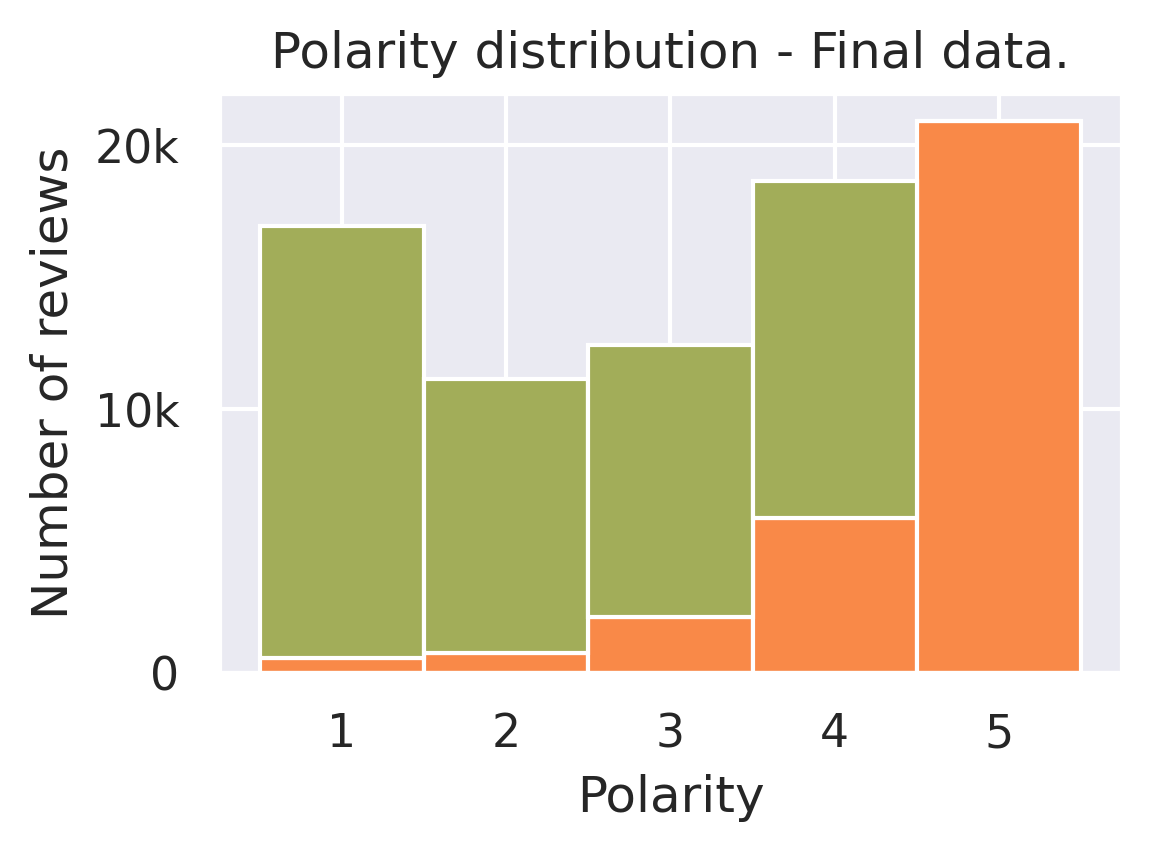

In [103]:
fig, ax = plt.subplots(figsize=(4,3))
x = [np.array(data['Polarity'].values), np.array(data2['Polarity'].values)]

ax.hist(x, bins=[0.001, 1.001, 2.001, 3.001, 4.001, 5.001],
        color = [ '#f98948', '#a2ad59'], stacked=True)

ax.set_title('Polarity distribution - Final data.')
ax.set_xlabel('Polarity')
ax.set_ylabel('Number of reviews')
ax.grid(True)
ax.set_yticks([0, 10000, 20000], [0, '10k', '20k'])
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5], [1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig('images/polarity_distribution_total.png')